In [1]:
# standard libary and settings
import os
import sys

import numpy as np
import pandas as pd
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    KFold,
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    LabelEncoder,
    OneHotEncoder,
    KBinsDiscretizer,
)
from sklearn.svm import SVC, SVR
from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder, BinaryEncoder, CountEncoder

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    from mlmachine.data import titanic
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasTransformer,
        KFoldEncoder,
        GroupbyImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style

c:\programdata\anaconda3\envs\petersont\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# import mlmachine as mlm
# from mlmachine.data import titanic

df_train, df_valid = titanic()

mlmachine_titanic = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings={"Pclass": [1, 2, 3]},
    is_classification=True,
)

>>> category label encoding

	0 --> 0
	1 --> 1



In [3]:
mlmachine_titanic.data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [4]:
mlmachine_titanic.target

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [5]:
mlmachine_titanic.data.mlm_dtypes

{'boolean': [],
 'nominal': ['Embarked', 'Sex'],
 'ordinal': ['Pclass'],
 'continuous': ['Age', 'Fare'],
 'count': ['Parch', 'SibSp'],
 'string': [],
 'date': [],
 'category': ['Embarked', 'Sex', 'Pclass'],
 'number': ['Age', 'Fare', 'Parch', 'SibSp']}

In [6]:
encode_pipe = PandasFeatureUnion([
    ("nominal_columns", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["nominal"]),
        PandasTransformer(OneHotEncoder()),
    )),
    ("other_columns", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["nominal"]),
    )),
])

mlmachine_titanic.data = encode_pipe.fit_transform(mlmachine_titanic.data.dropna(axis=0))
mlmachine_titanic.update_dtypes()

In [7]:
mlmachine_titanic.data.mlm_dtypes

{'boolean': [],
 'nominal': ['Embarked_C',
  'Embarked_Q',
  'Embarked_S',
  'Sex_female',
  'Sex_male'],
 'ordinal': ['Pclass'],
 'continuous': ['Age', 'Fare'],
 'count': ['Parch', 'SibSp'],
 'string': [],
 'date': [],
 'category': ['Embarked_C',
  'Embarked_Q',
  'Embarked_S',
  'Pclass',
  'Sex_female',
  'Sex_male'],
 'number': ['Age', 'Fare', 'Parch', 'SibSp']}

Feature summary Feature vs. target summary Statistical test 
 
 
 
 Age 
 
 
 
 
 count 
 712.000000 
 
 
 mean 
 29.642093 
 
 
 std 
 14.492933 
 
 
 min 
 0.420000 
 
 
 25% 
 20.000000 
 
 
 50% 
 28.000000 
 
 
 75% 
 38.000000 
 
 
 max 
 80.000000 
 
 
 missing 
 0.000000 
 
 
 skew 
 0.388060 
 
 
 kurtosis 
 0.178216 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Died 
 424.0 
 59.550562 
 30.626179 
 14.155388 
 
 
 Survived 
 288.0 
 40.449438 
 28.193299 
 14.833327 
 
 
 
 
 
 z-test statistic 
 p-value 
 
 
 
 
 2.2043 
 0.0275

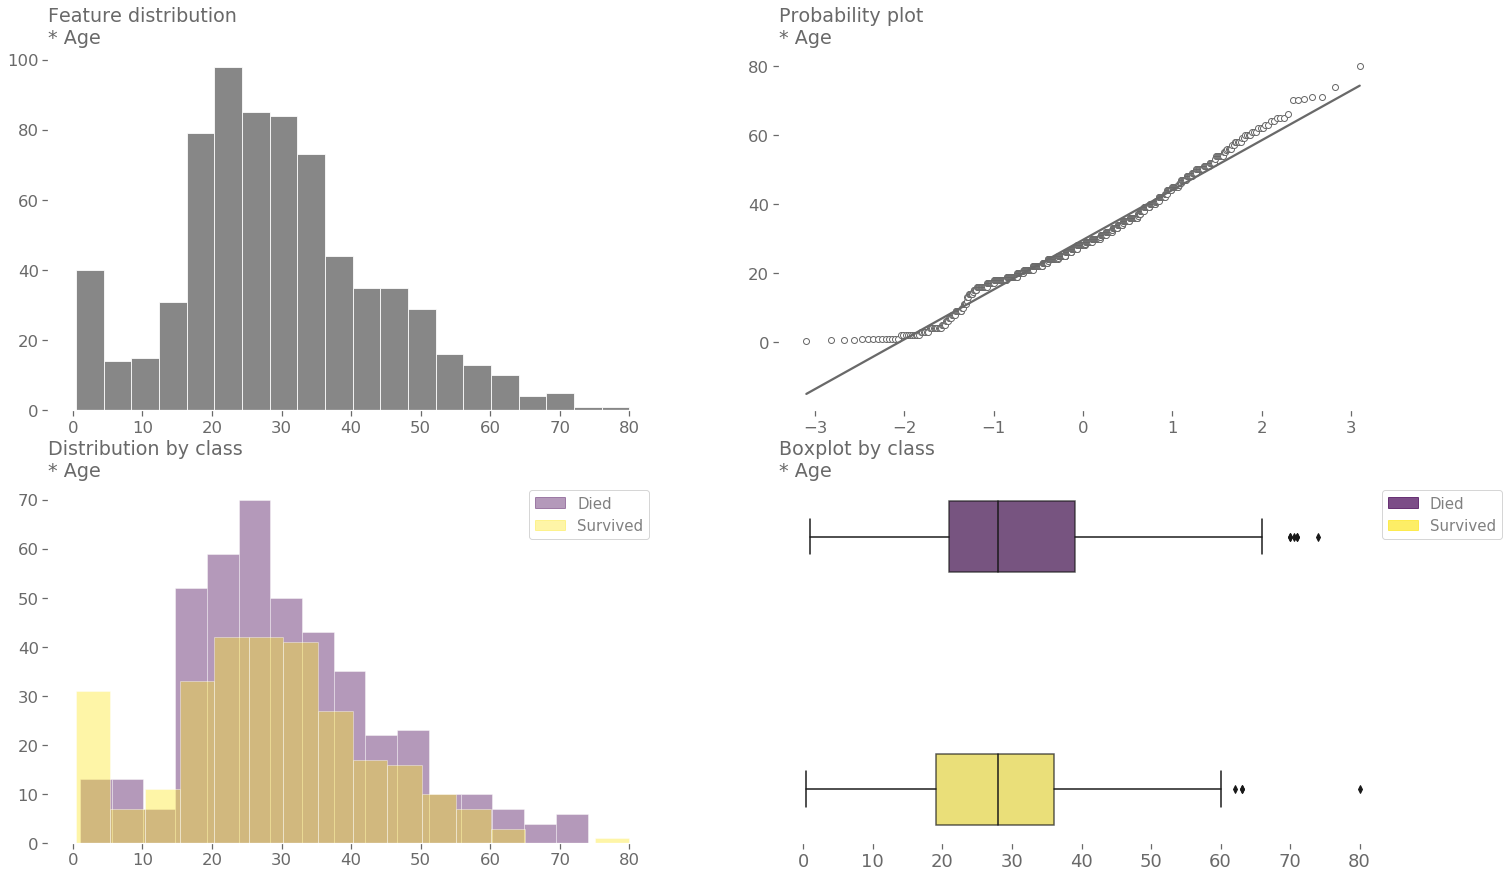

In [8]:
mlmachine_titanic.eda_cat_target_num_feat(
    feature="Age",
    legend_labels=["Died","Survived"],
)

>>> category label encoding

	0 --> 0
	1 --> 1
	2 --> 2



Feature summary,Feature vs. target summary
,alcalinity_of_ash
count,178.000000
mean,19.494944
std,3.339564
min,10.600000
25%,17.200000
50%,19.500000
75%,21.500000
max,30.000000
missing,0.000000


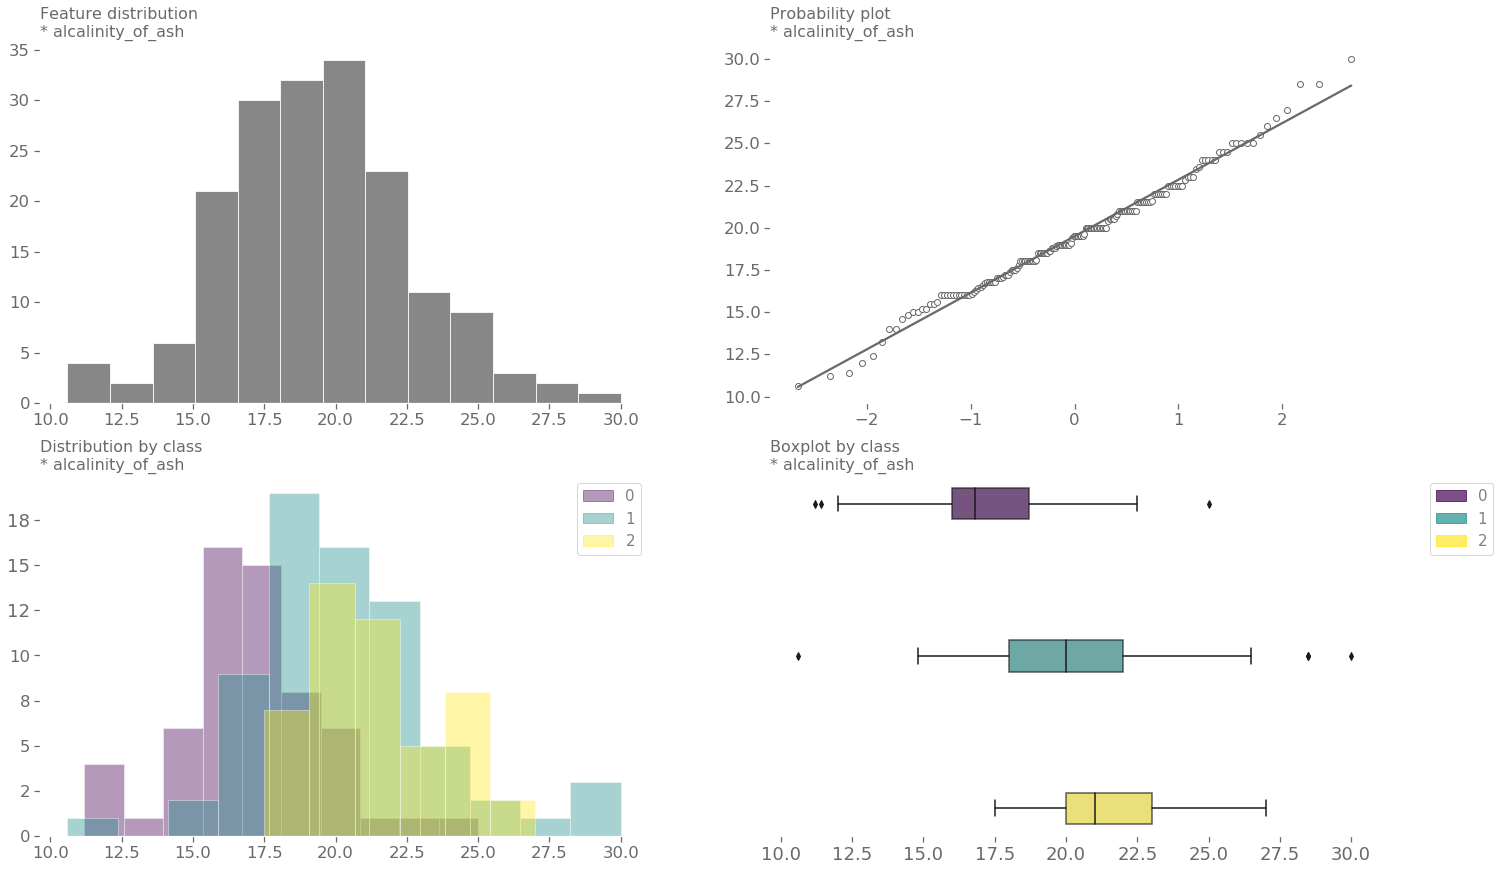

In [9]:
import sklearn.datasets as datasets

dataset = datasets.load_wine()
dataset = pd.merge(
            pd.DataFrame(dataset.data, columns=dataset.feature_names),
            pd.Series(dataset.target, name="Class label"),
            left_index=True,
            right_index=True,
        )

mlmachine_wine = mlm.Machine(
    data=dataset,
    identify_as_continuous=list(dataset.columns[:-1]),
    target="Class label",
    is_classification=True,
)

mlmachine_wine.eda_cat_target_num_feat(
    feature="alcalinity_of_ash",
)

Feature summary,Feature vs. target summary,Target proportion
SibSp,Count,Proportion
0,469,65.870787
1,183,25.702247
2,25,3.511236
4,18,2.528090
3,12,1.685393
5,5,0.702247
SibSp,Died,Survived
0,296,173
1,86,97


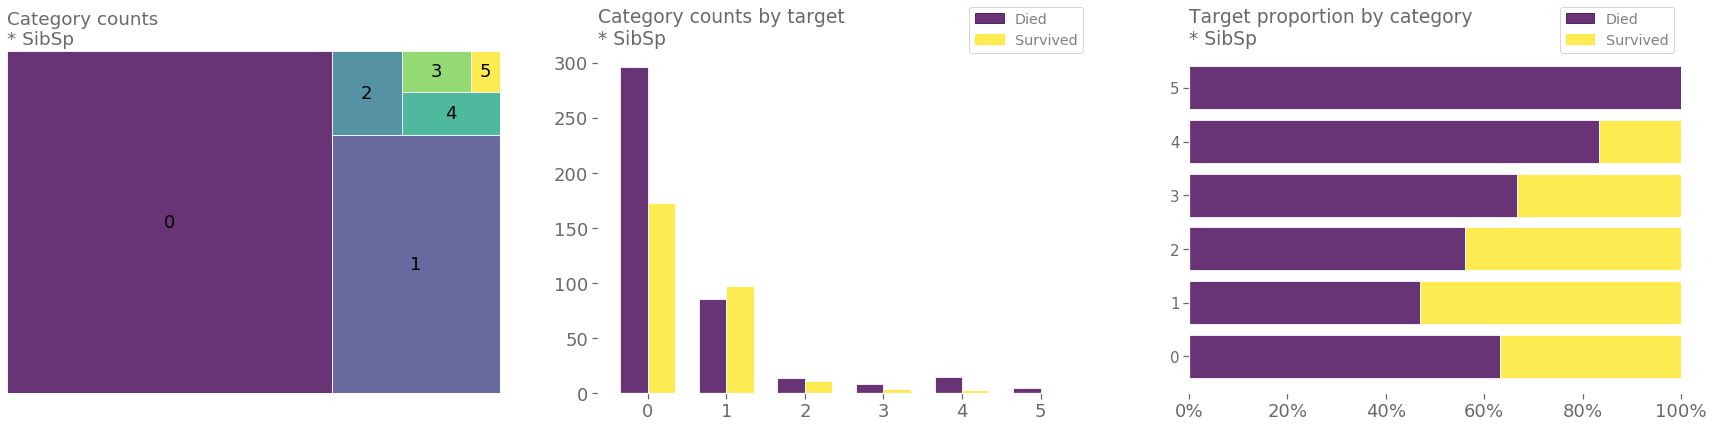

In [10]:
mlmachine_titanic.eda_cat_target_cat_feat(
    feature="SibSp",
    legend_labels=["Died","Survived"],
)

Feature summary Feature vs. target summary Target proportion 
 
 
 alcalinity_of_ash 
 Count 
 Proportion 
 
 
 
 
 3 
 42 
 23.595506 
 
 
 4 
 40 
 22.471910 
 
 
 1 
 36 
 20.224719 
 
 
 0 
 35 
 19.662921 
 
 
 2 
 25 
 14.044944 
 
 
 
 
 
 alcalinity_of_ash 
 0 
 1 
 2 
 
 
 
 
 0 
 27 
 8 
 0 
 
 
 1 
 15 
 15 
 6 
 
 
 2 
 9 
 11 
 5 
 
 
 3 
 6 
 18 
 18 
 
 
 4 
 2 
 19 
 19 
 
 
 
 
 
 Class 
 0 
 1 
 2 
 3 
 4 
 
 
 
 
 0 
 77.142857 
 41.666667 
 36.0 
 14.285714 
 5.0 
 
 
 1 
 22.857143 
 41.666667 
 44.0 
 42.857143 
 47.5 
 
 
 2 
 0.000000 
 16.666667 
 20.0 
 42.857143 
 47.5

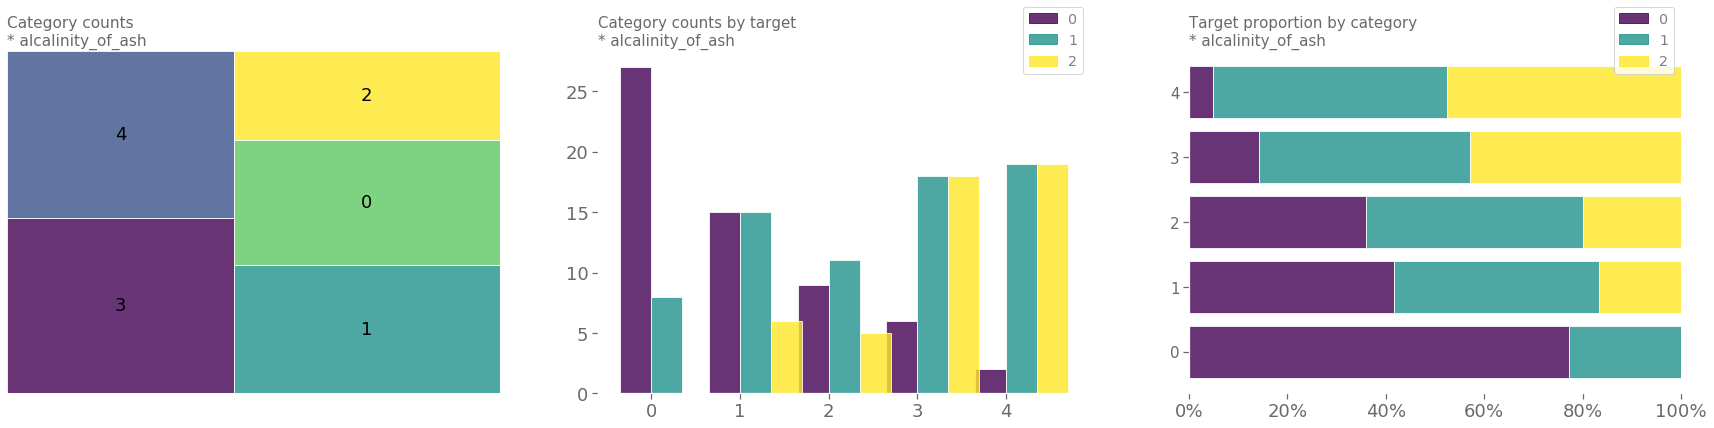

In [11]:
binner = KBinsDiscretizer(n_bins=5, encode="ordinal")

mlmachine_wine.data["alcalinity_of_ash"] = binner.fit_transform(
    mlmachine_wine.data["alcalinity_of_ash"].values.reshape(-1, 1)
)

mlmachine_wine.eda_cat_target_cat_feat(
    feature="alcalinity_of_ash",
)